<h1 align=center><font size = 5>Clustering Neighborhoods of Toronto</font></h1>

<a title="Flag designed by Renato De Santis.  The original uploader was a3r0 at  Wikimedia Commons. Updated image provided by MapGrid. [Public domain], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Flag_of_Toronto,_Canada.svg"><img width="200" alt="Flag of Toronto, Canada" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f2/Flag_of_Toronto%2C_Canada.svg/512px-Flag_of_Toronto%2C_Canada.svg.png"></a>

# Outline

The present notebook contains an analysis of the neioghborhoods of Toronto by means of data clustering. Relevant geographical data of the neoghborhoods of Toronto were derived from the following [Wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). The notebook is organized in the structure presented below:

<div class="alert alert-block alert-info" style="margin-top: 0px">

<font size = 3>

0. [Load and/or install required libraries](#0.-Load-libraries)

1. [Fetch data from the web and convert to a _pandas_ dataframe](#1.-Fetch-data-and-create-a-dataset)

2. [Add geographical coordinates of the neighborhoods to the dataframe](#2.-Add-geospatial-data)

3. [Clustering & analyzing the neighborhoods of Toronto](#3.-Toronto-clustering-and-analysis)
</font>

</div>

## 0. Load libraries

In [1]:
# Data and numeric
import numpy as np
import pandas as pd

# Geographic
# !conda install -c conda-forge geocoder --yes  ## uncomment this line to install `geocoder`
import geocoder
# !conda install -c conda-forge geopy --yes  ## uncomment this line to install `geopy`
from geopy.geocoders import Nominatim

# Graphics and rendering
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#import seaborn as sns
# !conda install -c conda-forge folium=0.10.0 --yes  ## uncomment this line to install `folium`
import folium

# JSON and web related
from IPython.display import display
import ipywidgets as widgets
import json
import requests
from pandas.io.json import json_normalize

# ML algos
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

## 1. Fetch data and create a dataset

Import the data from the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) and convert into a _pandas_ dataframe. The column header of the postal code is changed to **PostalCode**. The following modifications were also implemented:
- discard entries with **Borough** values marked as _Not assigned_ ;
- assign the **Borough** value to **Neighbourhood** if the latter is marked as _Not assigned_ ;
- define unique postal codes by merging all corresponding neighborhoods in a list inside a single row.

The total number of assigned postal code is printed in order to check the consistency of the modifications implemented in the dataset cleaning stage.

In [2]:
wiki_site = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(wiki_site)[0]
df.rename(columns={"Postcode": "PostalCode"}, inplace=True)

In [3]:
# Ignore entries with boroughs marked as 'Not assigned'
df.drop(df.loc[df['Borough'] == 'Not assigned'].index, inplace=True)
print("Total number of assigned postal code in Toronto: {:3d}".format(df.PostalCode.unique().size))

# Assign the borough name to neighborhoods marked as 'Not assigned'
df['Neighbourhood'][df['Neighbourhood'] == 'Not assigned'] = df['Borough'][df['Neighbourhood'] == 'Not assigned']

# Define unique postal codes by merging all corresponding neighborhoods in a single row
df = df.groupby(['PostalCode','Borough'])['Neighbourhood'].apply(list).apply(lambda l: ", ".join(l))
df = df.reset_index()

Total number of assigned postal code in Toronto: 103


In [4]:
# Print the first few entries of the cleansed dataset
df.head(10)

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [5]:
print("Dataset size: {:3d} rows x {:1d} columns.".format(df.shape[0],df.shape[1]))

Dataset size: 103 rows x 3 columns.


[Back to top](#Outline)

## 2. Add geospatial data

The Toronto neighborhoods dataset, as previously defined in `df`, is extended with the geographical coordinate data, i.e. latitude and longitute, of each postal code. A set of functions based on the `geocoder` package functionalities were defined for the task. Given no data could be retrieved with `geocoder`, [this](http://cocl.us/Geospatial_data) link to a `csv` file containing the geographical coordinates of each postal code was therefore used. The file is saved in the `data` folder archived with this notebook. The coordinate data are joined in the `df` dataset.
***
<i><font color='grey'>Not used</font></i>

In [6]:
# Retrieve the latitude of a postal code of Toronto, with maximum 10 Google API calls
def get_Toronto_zip_latitude(postal_code):
    latlng = None
    c = 0
    while(latlng is None and c < 10):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        latlng = g.latlng
        c += 1
    #
    return 'N/A' if latlng is None else latlng[0]

In [7]:
# Retrieve the longitude of a postal code of Toronto, with maximum 10 Google API calls
def get_Toronto_zip_longitude(postal_code):
    latlng = None
    c = 0
    while(latlng is None and c < 10):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        latlng = g.latlng
        c += 1
    #
    return 'N/A' if latlng is None else latlng[1]

***
Add the geospatial coordinates from the source file:

In [8]:
# Fetch postal code coordinates from file and merge in the `df` dataframe
loc_df = pd.read_csv('data/Geospatial_Coordinates.csv')
loc_df.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
df = df.join(loc_df.set_index('PostalCode'), on='PostalCode')

In [9]:
# Print the first few entries of the updated dataset
df.head(10)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


[Back to top](#Outline)

## 3. Toronto clustering and analysis

This section contains the instructions aimed at performing a clustering of the neighbourhoods of Toronto, including some preliminary exploratory analysis of the data. Further, the clusters structure and properties are examined. This section is subdivided in steps desribed in the following.

### Foursquare credentials

The next cells define the Foursquare developer account credentials to access the Foursquare API. Insert the corresponding Foursquare credentials in the following text areas:

In [10]:
# Define string text area widgets for the input of Foursquare client ID and Secret and bind to variables
client_id = widgets.Text(
    value='Foursquare Client ID',
    description='Client ID:',
    disabled=False,
    layout=widgets.Layout(width='80%', height='30px')
)
client_pw = widgets.Text(
    value='Foursquare Client Secret',
    description='Client Secret:',
    disabled=False,
    layout=widgets.Layout(width='80%', height='30px')
)
display(client_id)
display(client_pw)

def bind_id(sender):
    client_id.value

def bind_pw(sender):
    client_pw.value

client_id.on_submit(bind_id)
client_pw.on_submit(bind_pw)

Text(value='Foursquare Client ID', description='Client ID:', layout=Layout(height='30px', width='80%'))

Text(value='Foursquare Client Secret', description='Client Secret:', layout=Layout(height='30px', width='80%')…

In [11]:
# Show Foursquare client ID, Secret and API version
cl_id = client_id.value
cl_pw = client_pw.value
ver_api = '20180605'
print("    Client ID: {:s}".format(cl_id))
print("Client Secret: {:s}".format(cl_pw))
print("  API version: {:s}".format(ver_api))

    Client ID: U12V3RJKHKCDS2ZMHUGZOER5USD4PIX2TDGODNJ20L33MK3J
Client Secret: 0LJUM1SSHRNIMVHKYLNTD4FGI4SWWZSSJ1N0AACGUCVWP0SR
  API version: 20180605


[Back to top](#Outline)

### Map of the neighbourhoods of Toronto

This section illustrates the neighbourhoods of Toronto from the dataset `df` previously defined.

In [12]:
# Get coordinates of Toronto
gl = Nominatim(user_agent="toronto")
to = gl.geocode('Toronto, ON')
to_lat = to.latitude
to_lon = to.longitude
print('The geograpical coordinate of Toronto are: lat = {:8.4f}, lon = {:8.4f}.'.format(to_lat, to_lon))

The geograpical coordinate of Toronto are: lat =  43.6540, lon = -79.3872.


In [13]:
# Show the map of Toronto along with the neighborhoods and postal codes
map_toronto = folium.Map(location=[to_lat, to_lon], zoom_start=11)
for lat, lng, bor, zpc in zip(df['Latitude'], df['Longitude'], df['Borough'], df['PostalCode']):
    label = '{:s}'.format(bor)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        tooltip=zpc,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

[Back to top](#Outline)

### Explore neighbourhoods in Toronto

In this section only the boroughs containing the string `Toronto` will be considered for the analysis. Those only neighborhoods will be explored through the Foursquare data queries. The `getNearbyVenues` function defined in the previous ungraded Lab will be slightly modified and borrowed for the purpose.

In [15]:
# Get only boroughs containing the string "Toronto"
boros = [b for b in df["Borough"].unique().tolist() if "Toronto" in b]

# Define a smaller dataset of the central neighbourhoods in Toronto
df_central_toronto = df[df['Borough'].isin(boros)]
df_central_toronto.head(10)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
49,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


In [16]:
df_central_toronto.shape

(38, 5)

In [17]:
# Function to get the venues data within a certain radius from a given location
def get_nearby_venues(names, latitudes, longitudes, radius=500, maxq=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            cl_id, 
            cl_pw, 
            ver_api, 
            lat, 
            lng, 
            radius, 
            maxq)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    #
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    #
    return(nearby_venues)

We fetch venues data for each neighbourhood of central Toronto, as defined in the `df_central_toronto` dataframe, with a searching radius of 300 m and accounting for a maximum number of 100 venues per neighbourhood:

In [18]:
# Get venues for the entries of `df_central_toronto`
toronto_venues = get_nearby_venues(names=df_central_toronto['Neighbourhood'],
                                   latitudes=df_central_toronto['Latitude'],
                                   longitudes=df_central_toronto['Longitude'],
                                   radius=300)

In [19]:
# Print a summary of the data received
print("Dataset size: {:4d} rows x {:1d} columns.".format(toronto_venues.shape[0],toronto_venues.shape[1]))
toronto_venues.head(10)

Dataset size:  947 rows x 7 columns.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park
2,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
3,The Beaches,43.676357,-79.293031,Best Bathtub in the Beaches,43.674591,-79.293602,Spa
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
5,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop
6,"The Danforth West, Riverdale",43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop
7,"The Danforth West, Riverdale",43.679557,-79.352188,Louis Cifer Brew Works,43.677663,-79.351313,Brewery
8,"The Danforth West, Riverdale",43.679557,-79.352188,Messini Authentic Gyros,43.677827,-79.350569,Greek Restaurant
9,"The Danforth West, Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant


In [20]:
# Show venue counts per neighbourhood
toronto_count = toronto_venues[['Neighborhood','Venue']].groupby('Neighborhood').count()
toronto_count.rename(columns={'Venue':'Venue counts'})

,Venue counts
Neighborhood,
"Adelaide, King, Richmond",60
Berczy Park,7
"Brockton, Exhibition Place, Parkdale Village",18
Business Reply Mail Processing Centre 969 Eastern,7
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",5
"Cabbagetown, St. James Town",20
Central Bay Street,35
"Chinatown, Grange Park, Kensington Market",69
Christie,8


[Back to top](#Outline)

### Analyze the neighbourhoods of Toronto

In this section the Foursquare data previously recorder in the `toronto_venues` dataframe are analyzed. The same approach presented in the ungraded Lab of New York is adopted, namely the venue categories are encoded as features of a new dataset on top of which the clustering algorithm will operate.

In [21]:
# Show the number of categories of the venues in central Toronto
print('There are {:3d} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 185 uniques categories.


The dataframe contains the total number of occurrences of a specific category for each neighbourhood and is stored as `toronto_venues_df`:

In [22]:
# one hot encoding of the venue categories and recast of the dataset
toronto_venues_df = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_venues_df['Neighbourhood'] = toronto_venues['Neighborhood']
cols = [toronto_venues_df.columns[-1]] + list(toronto_venues_df.columns[:-1])
toronto_venues_df = toronto_venues_df[cols].groupby('Neighbourhood').sum().reset_index()

In [23]:
# Print the shape of the dataset
print("Dataset size: {:3d} rows x {:3d} columns.".format(toronto_venues_df.shape[0],toronto_venues_df.shape[1]))
toronto_venues_df.head(10)

Dataset size:  37 rows x 186 columns.


,Neighbourhood,Adult Boutique,Airport Food Court,Airport Gate,Airport Lounge,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0,0,0,0,0,3,0,0,3,...,0,0,2,0,0,0,0,0,0,0
1,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Brockton, Exhibition Place, Parkdale Village",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,Business Reply Mail Processing Centre 969 Eastern,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Chinatown, Grange Park, Kensington Market",0,0,0,0,0,0,0,1,0,...,0,0,4,0,3,0,1,0,0,0
8,Christie,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Church and Wellesley,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0


Some characteristics of `toronto_venues_df` dataframe are given here. The same (though adapted) code presented in the ungraded Lab of New York is used:

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

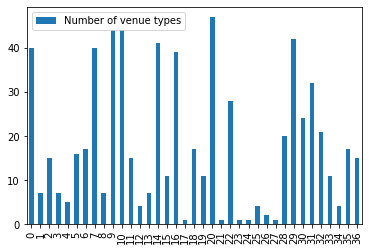

In [25]:
# check how many non-zero entries are there per neighbourhood
toronto_tot_features = pd.DataFrame(columns=['Neighbourhood','Number of venue types'])
toronto_tot_features['Neighbourhood'] = toronto_venues_df['Neighbourhood']
toronto_tot_features['Number of venue types'] = toronto_venues_df.drop('Neighbourhood',1).apply(lambda x: x > 0).sum(axis=1)
toronto_tot_features.plot.bar()
plt.show()

We create a dataframe accounting for the 4 most common venues per neihbourhood. The value of 4 is selected in order to minimize the bias that may arise by accounting for venues that would be randomly picked but are not actually present if the value were too high. The value was selected by looking at the chart above.

In [26]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_venues_df['Neighbourhood']

for ind in np.arange(toronto_venues_df.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_venues_df.iloc[ind, :],
                                                                          num_top_venues)
# Print the 10 most frequent venues summary
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Steakhouse,Asian Restaurant,Hotel
1,Berczy Park,Concert Hall,Italian Restaurant,Breakfast Spot,Steakhouse
2,"Brockton, Exhibition Place, Parkdale Village",Gym,Café,Sandwich Place,Japanese Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Park,Garden,Light Rail Station,Fast Food Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Food Court,Airport Gate,Airport Lounge,Airport Terminal


[Back to top](#Outline)

### Clustering the neighbourhoods

In this section the _k_-means clustering algorithm is applied  on the `toronto_venues_df` dataframe. Different values of the clusters number are used and the corresponding clustering is presented in different maps below:

In [27]:
# Transform the data with a Min-Max scaler
toronto_data = MinMaxScaler().fit_transform(toronto_venues_df.values[:,1:])

# Run the k-means algo for 3,4 and 5 clusters
k3 = KMeans(init="k-means++", n_clusters=3, n_init=10, random_state=0)
k3.fit(toronto_data)
k4 = KMeans(init="k-means++", n_clusters=4, n_init=10, random_state=0)
k4.fit(toronto_data)
k5 = KMeans(init="k-means++", n_clusters=5, n_init=10, random_state=0)
k5.fit(toronto_data)

# Collect the clustering labels for each algo and print the results
kmeans_results = pd.DataFrame(columns=['k = 3','k = 4','k = 5'])
kmeans_results['k = 3'] = k3.labels_
kmeans_results['k = 4'] = k4.labels_
kmeans_results['k = 5'] = k5.labels_
kmeans_results.head(10)

,k = 3,k = 4,k = 5
0,2,0,1
1,0,1,1
2,0,1,1
3,0,1,1
4,0,1,1
5,0,1,1
6,2,1,1
7,2,2,2
8,0,1,1
9,2,1,1


In [28]:
# Add the cluster labels to the venue dataset for each clustering algo
# Num of clusters = 3
df_toronto_merged  = df_central_toronto.drop(['PostalCode','Borough'],1)
df_toronto_merged3 = df_toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'),
                                            on='Neighbourhood', how='right')
df_toronto_merged3.insert(0, 'Cluster Labels', k3.labels_)
# Num of clusters = 4
df_toronto_merged4 = df_toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'),
                                            on='Neighbourhood', how='right')
df_toronto_merged4.insert(0, 'Cluster Labels', k4.labels_)
# Num of clusters = 5
df_toronto_merged5 = df_toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'),
                                            on='Neighbourhood', how='right')
df_toronto_merged5.insert(0, 'Cluster Labels', k5.labels_)

In [29]:
# Function that returns a map of the neighbourhoods grouped into the clusters
def map_with_clusters(latitude, longitude, dataset, algorithm):
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
    
    # set color scheme for the clusters
    kclusters = algorithm.n_clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(dataset['Latitude'],
                                      dataset['Longitude'],
                                      dataset['Neighbourhood'],
                                      dataset['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=2,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.5).add_to(map_clusters)
    
    return map_clusters

In [32]:
# Create map for 3 clusters
map_with_clusters(to_lat, to_lon, df_toronto_merged3, k3)

In [33]:
# Create map for 4 clusters
map_with_clusters(to_lat, to_lon, df_toronto_merged4, k4)

In [34]:
# Create map for 5 clusters
map_with_clusters(to_lat, to_lon, df_toronto_merged5, k5)

[Back to top](#Outline)

### Brief cluster analysis

Cluster categories for the _k_-means algorithm with 3 clusters:

In [35]:
df_toronto_merged3.loc[df_toronto_merged3['Cluster Labels'] == 0,
                       df_toronto_merged3.columns[[1] + list(range(4, df_toronto_merged3.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
41,"The Danforth West, Riverdale",Greek Restaurant,Ice Cream Shop,Yoga Studio,Italian Restaurant
42,"The Beaches West, India Bazaar",Park,Ice Cream Shop,Burger Joint,Liquor Store
43,Studio District,Coffee Shop,Café,Italian Restaurant,Comfort Food Restaurant
44,Lawrence Park,Photography Studio,Yoga Studio,Dog Run,Fish Market
45,Davisville North,Breakfast Spot,Convenience Store,Gym,Pool
48,"Moore Park, Summerhill East",Park,Yoga Studio,Donut Shop,Flower Shop
51,"Cabbagetown, St. James Town",Café,Coffee Shop,Restaurant,Pizza Place
52,Church and Wellesley,Gay Bar,Burger Joint,Coffee Shop,Japanese Restaurant
53,Harbourfront,Gym / Fitness Center,History Museum,Bakery,Coffee Shop
55,St. James Town,Coffee Shop,Gastropub,Restaurant,Italian Restaurant


In [36]:
df_toronto_merged3.loc[df_toronto_merged3['Cluster Labels'] == 1,
                       df_toronto_merged3.columns[[1] + list(range(4, df_toronto_merged3.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
50,Rosedale,Park,Building,Yoga Studio,Donut Shop
54,"Ryerson, Garden District",Coffee Shop,Middle Eastern Restaurant,Café,Hotel
56,Berczy Park,Concert Hall,Italian Restaurant,Breakfast Spot,Steakhouse


In [37]:
df_toronto_merged3.loc[df_toronto_merged3['Cluster Labels'] == 2,
                       df_toronto_merged3.columns[[1] + list(range(4, df_toronto_merged3.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
37,The Beaches,Park,Other Great Outdoors,Trail,Spa
46,North Toronto West,Sushi Restaurant,Yoga Studio,Food & Drink Shop,Flower Shop
47,Davisville,Dessert Shop,Café,Italian Restaurant,Coffee Shop
49,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Coffee Shop,Liquor Store,Light Rail Station,Supermarket
60,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Restaurant,Deli / Bodega,Bakery
75,Christie,Grocery Store,Gym / Fitness Center,American Restaurant,Café
76,"Dovercourt Village, Dufferin",Gym / Fitness Center,Music Venue,Supermarket,Middle Eastern Restaurant


Cluster categories for the _k_-means algorithm with 4 clusters:

In [38]:
df_toronto_merged4.loc[df_toronto_merged4['Cluster Labels'] == 0,
                       df_toronto_merged4.columns[[1] + list(range(4, df_toronto_merged4.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
37,The Beaches,Park,Other Great Outdoors,Trail,Spa
50,Rosedale,Park,Building,Yoga Studio,Donut Shop
54,"Ryerson, Garden District",Coffee Shop,Middle Eastern Restaurant,Café,Hotel
56,Berczy Park,Concert Hall,Italian Restaurant,Breakfast Spot,Steakhouse
60,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Restaurant,Deli / Bodega,Bakery
63,Roselawn,Health & Beauty Service,Yoga Studio,Dog Run,Fish Market
70,"First Canadian Place, Underground city",Coffee Shop,Deli / Bodega,Café,Salad Place


In [39]:
df_toronto_merged4.loc[df_toronto_merged4['Cluster Labels'] == 1,
                       df_toronto_merged4.columns[[1] + list(range(4, df_toronto_merged4.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
41,"The Danforth West, Riverdale",Greek Restaurant,Ice Cream Shop,Yoga Studio,Italian Restaurant
42,"The Beaches West, India Bazaar",Park,Ice Cream Shop,Burger Joint,Liquor Store
43,Studio District,Coffee Shop,Café,Italian Restaurant,Comfort Food Restaurant
44,Lawrence Park,Photography Studio,Yoga Studio,Dog Run,Fish Market
45,Davisville North,Breakfast Spot,Convenience Store,Gym,Pool
46,North Toronto West,Sushi Restaurant,Yoga Studio,Food & Drink Shop,Flower Shop
48,"Moore Park, Summerhill East",Park,Yoga Studio,Donut Shop,Flower Shop
49,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Coffee Shop,Liquor Store,Light Rail Station,Supermarket
51,"Cabbagetown, St. James Town",Café,Coffee Shop,Restaurant,Pizza Place
52,Church and Wellesley,Gay Bar,Burger Joint,Coffee Shop,Japanese Restaurant


In [40]:
df_toronto_merged4.loc[df_toronto_merged4['Cluster Labels'] == 2,
                       df_toronto_merged4.columns[[1] + list(range(4, df_toronto_merged4.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
47,Davisville,Dessert Shop,Café,Italian Restaurant,Coffee Shop


In [41]:
df_toronto_merged4.loc[df_toronto_merged4['Cluster Labels'] == 3,
                       df_toronto_merged4.columns[[1] + list(range(4, df_toronto_merged4.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
76,"Dovercourt Village, Dufferin",Gym / Fitness Center,Music Venue,Supermarket,Middle Eastern Restaurant


Cluster categories for the _k_-means algorithm with 5 clusters:

In [42]:
df_toronto_merged5.loc[df_toronto_merged5['Cluster Labels'] == 0,
                       df_toronto_merged5.columns[[1] + list(range(4, df_toronto_merged5.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
76,"Dovercourt Village, Dufferin",Gym / Fitness Center,Music Venue,Supermarket,Middle Eastern Restaurant


In [43]:
df_toronto_merged5.loc[df_toronto_merged5['Cluster Labels'] == 1,
                       df_toronto_merged5.columns[[1] + list(range(4, df_toronto_merged5.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
37,The Beaches,Park,Other Great Outdoors,Trail,Spa
41,"The Danforth West, Riverdale",Greek Restaurant,Ice Cream Shop,Yoga Studio,Italian Restaurant
42,"The Beaches West, India Bazaar",Park,Ice Cream Shop,Burger Joint,Liquor Store
43,Studio District,Coffee Shop,Café,Italian Restaurant,Comfort Food Restaurant
44,Lawrence Park,Photography Studio,Yoga Studio,Dog Run,Fish Market
45,Davisville North,Breakfast Spot,Convenience Store,Gym,Pool
46,North Toronto West,Sushi Restaurant,Yoga Studio,Food & Drink Shop,Flower Shop
48,"Moore Park, Summerhill East",Park,Yoga Studio,Donut Shop,Flower Shop
49,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Coffee Shop,Liquor Store,Light Rail Station,Supermarket
51,"Cabbagetown, St. James Town",Café,Coffee Shop,Restaurant,Pizza Place


In [44]:
df_toronto_merged5.loc[df_toronto_merged5['Cluster Labels'] == 2,
                       df_toronto_merged5.columns[[1] + list(range(4, df_toronto_merged5.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
47,Davisville,Dessert Shop,Café,Italian Restaurant,Coffee Shop


In [45]:
df_toronto_merged5.loc[df_toronto_merged5['Cluster Labels'] == 3,
                       df_toronto_merged5.columns[[1] + list(range(4, df_toronto_merged5.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
50,Rosedale,Park,Building,Yoga Studio,Donut Shop
54,"Ryerson, Garden District",Coffee Shop,Middle Eastern Restaurant,Café,Hotel
56,Berczy Park,Concert Hall,Italian Restaurant,Breakfast Spot,Steakhouse


In [46]:
df_toronto_merged5.loc[df_toronto_merged5['Cluster Labels'] == 4,
                       df_toronto_merged5.columns[[1] + list(range(4, df_toronto_merged5.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
60,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Restaurant,Deli / Bodega,Bakery


The previous cells showed that despite small differences all the _k_-means algorithms presented identify a major cluster that represent neighbourhoods with predominant presence of Cafe and Coffee shops. The map at the bottom shows the major cluster of the different _k_-means algorithms with the following markers:
- big blue circle, for _k_-means with $k = 3$
- medium green circle, for _k_-means with $k = 4$
- small red circle, for _k_-means with $k = 5$

In [47]:
# Show the map of the venues of the main cluster of each algo
map_1st_cluster = folium.Map(location=[to_lat, to_lon], zoom_start=12)
k3_df = df_toronto_merged3[df_toronto_merged3['Cluster Labels'] == 0]
k4_df = df_toronto_merged4[df_toronto_merged4['Cluster Labels'] == 1]
k5_df = df_toronto_merged5[df_toronto_merged5['Cluster Labels'] == 1]
for lat, lng, in zip(k3_df['Latitude'], k3_df['Longitude']):
    label = 'k = 3'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_1st_cluster)
for lat, lng, in zip(k4_df['Latitude'], k4_df['Longitude']):
    label = 'k = 4'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_1st_cluster)
for lat, lng, in zip(k5_df['Latitude'], k5_df['Longitude']):
    label = 'k = 5'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_1st_cluster)
    
map_1st_cluster

[Back to top](#Outline)